## Creating time-series model for attendance prediction

### Importing necessary packages

In [55]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

#### Create synthetic data for training the model

In [153]:
# Define parameters
num_days = 100
mean_attendance = 0.59  # Mean attendance rate
std_dev_attendance = 0.2  # Standard deviation of attendance rate

# Generate synthetic attendance data
attendance_data = np.random.binomial(1, mean_attendance, num_days)
print(attendance_data)

[0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0
 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1]


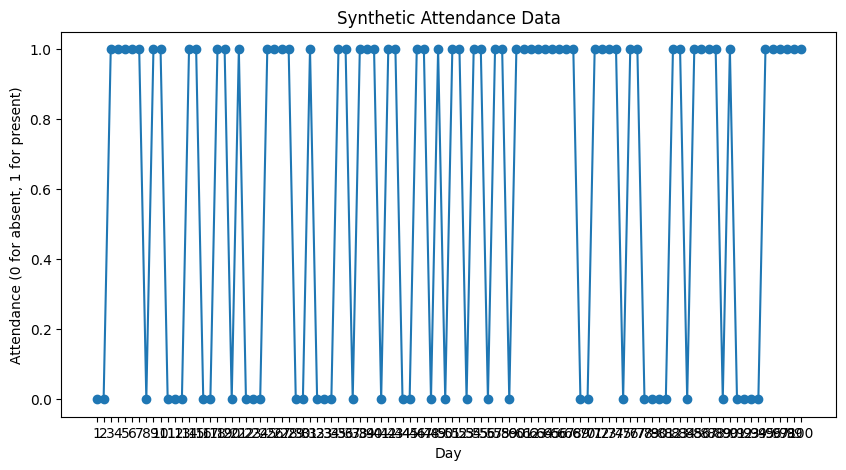

In [154]:
# Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_days + 1), attendance_data, marker='o', linestyle='-')
plt.title('Synthetic Attendance Data')
plt.xlabel('Day')
plt.ylabel('Attendance (0 for absent, 1 for present)')
plt.xticks(np.arange(1, num_days + 1, 1))
plt.show()

In [155]:
import pandas as pd
# Making it into a dataframe
data_dict = {i+1: attendance_data[i] for i in range(45)}

data_df = pd.DataFrame(list(data_dict.items()), columns=['ID', 'Attendance'])
data_df.head()

,ID,Attendance
0,1,0
1,2,0
2,3,1
3,4,1
4,5,1


In [156]:
# Checking out the count of samples
len(data_df)

45

In [157]:
indexes = [i for i in range(1, 46)]
status = [attendance_data[i] for i in range(45)]
print(indexes)
print(status)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0]


In [158]:
# Creating the train and test sets
split_size = int(0.8 * len(indexes)) # 80% train, 20% test split

# Create train data split
X_train, y_train = indexes[:split_size], status[:split_size]

# Create test data split
X_test, y_test = indexes[split_size:], status[split_size:]

# Checking out the length of the train and test sets of the time-series data
len(X_train), len(y_train), len(X_test), len(y_test)

(36, 36, 9, 9)

### Creating a function to visualize the data

In [159]:
# Create function to plot the time-series data
def plot_time_series(indexes, status, format='-', start = 0,end = None, label = None):
  # Plot the series
  plt.plot(indexes[start:end], status[start:end], format, label=label)
  plt.xlabel('Indexes')
  plt.ylabel('Status')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

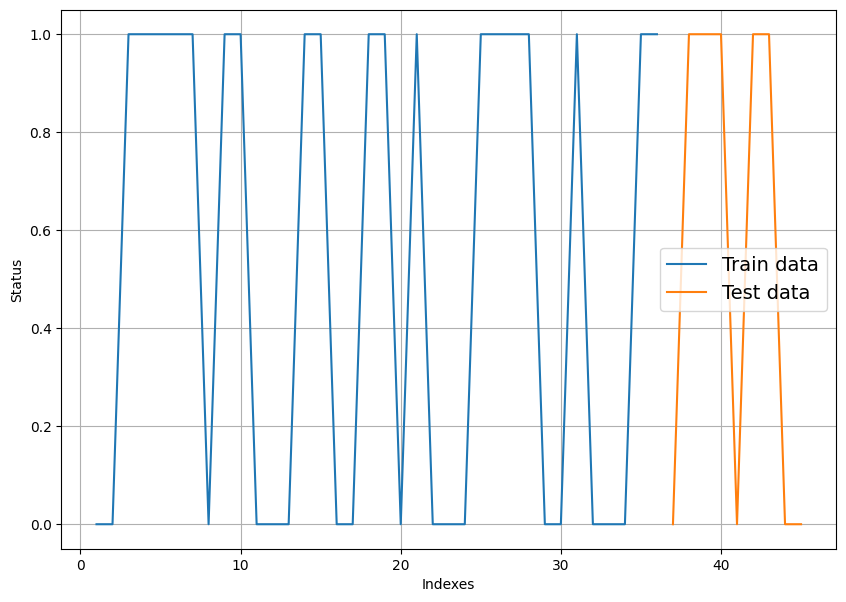

In [160]:
# Testing out the plotting function
plt.figure(figsize=(10, 7))

plot_time_series(indexes = X_train, status = y_train, label='Train data')
plot_time_series(indexes = X_test, status = y_test, label='Test data')

### Windowing the data, accordingly to the horizon and window size

In [161]:
# Create function to create windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.
  e.g. if horizon = 1,
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [162]:
# Checking out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window : {tf.squeeze(test_window).numpy()} -> Label : {tf.squeeze(test_label).numpy()}")

Window : [0 1 2 3 4 5 6] -> Label : 7


In [163]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [164]:
full_windows, full_labels = make_windows(attendance_data, window_size = 7, horizon = 1)
len(full_windows), len(full_labels)

(93, 93)

In [165]:
# View the first 5 window / labels
for i in range(5):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} \n")

Window: [0 0 1 1 1 1 1] -> Label: [0] 

Window: [0 1 1 1 1 1 0] -> Label: [1] 

Window: [1 1 1 1 1 0 1] -> Label: [1] 

Window: [1 1 1 1 0 1 1] -> Label: [0] 

Window: [1 1 1 0 1 1 0] -> Label: [0] 



### Turning the windowed data into train and test sets

In [166]:
# Make the train / test splits
def make_train_test_splits(windows, labels, test_split = 0.2):
  """
  Splits matching pairs of windows and labels into training and test splits
  """
  split_size = int(len(windows) * (1 - test_split))  # this will default to 80% train, 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]

  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [167]:
# Create the train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(74, 19, 74, 19)

In [168]:
# Checking out the first 5 elements of the train and test data splits
test_windows[:5], test_labels[:5]

(array([[0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 1]]),
 array([[1],
        [1],
        [0],
        [1],
        [1]]))

In [169]:
train_windows[:5], train_labels[:5]

(array([[0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 0]]),
 array([[0],
        [1],
        [1],
        [0],
        [0]]))

### Making evaluation metrics for the model

In [170]:
def evaluate_preds(y_true, y_pred):
  # data must in float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate evaluation metrics
  acc = tf.keras.metrics.accuracy(y_true, y_pred)

  # Account for different sized metrics
  if acc.ndim > 0:
    acc = tf.reduce_mean(acc)

  return {"acc": acc.numpy()}

### Creating model checkpoint to get the model with best parameters

In [171]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = 'model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            monitor = 'val_loss',
                                            verbose = 0, # only output a limited amount of text
                                            save_best_only = True
                                            )

In [172]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on the input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

### Creating the model for the time series data

In [173]:
HORIZON = 1
WINDOW_SIZE = 7

In [174]:
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# Create the lstm model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
x = layers.LSTM(128, return_sequences = True, activation='relu')(x)
x = layers.LSTM(128, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
outputs = layers.Dense(HORIZON, activation="sigmoid")(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model')

In [175]:
# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [176]:
# Fit the model
model_history = model.fit(train_windows,
                              train_labels,
                              batch_size = 8,
                              epochs = 30,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(model_name = model.name)]
                              )

Epoch 1/30
10/10 [==============================] - 8s 445ms/step - loss: 0.6922 - accuracy: 0.5676 - val_loss: 0.6880 - val_accuracy: 0.6842
Epoch 2/30
10/10 [==============================] - 4s 482ms/step - loss: 0.6904 - accuracy: 0.5811 - val_loss: 0.6821 - val_accuracy: 0.6842
Epoch 3/30
10/10 [==============================] - 4s 482ms/step - loss: 0.6869 - accuracy: 0.5811 - val_loss: 0.6786 - val_accuracy: 0.6842
Epoch 4/30
10/10 [==============================] - 7s 784ms/step - loss: 0.6860 - accuracy: 0.5811 - val_loss: 0.6714 - val_accuracy: 0.6842
Epoch 5/30
10/10 [==============================] - 4s 476ms/step - loss: 0.6825 - accuracy: 0.5811 - val_loss: 0.6677 - val_accuracy: 0.6842
Epoch 6/30
10/10 [==============================] - 4s 399ms/step - loss: 0.6798 - accuracy: 0.5811 - val_loss: 0.6634 - val_accuracy: 0.6842
Epoch 7/30
10/10 [==============================] - 4s 403ms/step - loss: 0.6777 - accuracy: 0.5811 - val_loss: 0.6596 - val_accuracy: 0.6842
Epoch 

In [178]:
# Evaluate the model on the test set
model.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 50ms/step - loss: 0.8510 - accuracy: 0.6842


[0.8509737253189087, 0.6842105388641357]

In [180]:
# Load in the bests performing model
best_model = tf.keras.models.load_model('model_experiments/model/')
best_model.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 449ms/step - loss: 0.6519 - accuracy: 0.6842


[0.6519299149513245, 0.6842105388641357]

In [181]:
# Get the forecast predictions
model_preds = make_preds(model,
                         input_data = test_windows)

1/1 [==============================] - 1s 526ms/step


In [185]:
# Convert the prediction probabilities into prediction labels
np.round(model_preds)

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1.], dtype=float32)

### Convert the best model data and download it

In [184]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Example usage
folder_to_zip = 'model_experiments/model/'
zip_file = 'best_model.zip'

zip_folder(folder_to_zip, zip_file)